In [50]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from qutip import *
from scipy import interpolate as sp

In [3]:
hbar = 1.054571817e-34
C = 1e-12 # Circuit capacitance 1 pF
C_c = 1e-15 # Coupling capacitance 1 fF
C_tot = C + C_c
omega = 2*np.pi*5e9 # qubit frequency 5 GHz
T_sep = 2*np.pi/omega # time between pulses
K_j = 483597.8484e9 # flux quantum Hz/V
V_max = 2e-3 # pulse height 2 mV
pulse_width = 1/(V_max*K_j)
print(pulse_width*1e12,' ps')

1.033916924267275  ps


In [4]:
def ddf(x,width):
    val = np.zeros_like(x)
    val[(-(width/2)<=x) & (x<=(width/2))] = 1
    return val

def sfq_pulses(n,T_sep):
    t = np.linspace(0,T_sep*n,n*1000)
    pulses = V_max*ddf(t,pulse_width)
    for i in range(n):
        pulses = np.add(pulses,V_max*ddf(t-T_sep*(i+1),pulse_width))
    return t,pulses


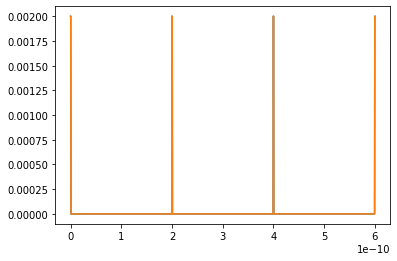

In [53]:
t,pulses = sfq_pulses(3,T_sep)
fsfq = sp.interp1d(t,pulses)
plt.plot(t,pulses)
plt.plot(t,fsfq(t))

In [8]:
t,V_sfq = sfq_pulses(40,T_sep)

def transmon_hamiltonian(Ec=0.386, EjEc=45, nstates=8, ng=0.0, T=10.0):
    """Transmon Hamiltonian

    Args:
        Ec: capacitive energy
        EjEc: ratio `Ej` / `Ec`
        nstates: defines the maximum and minimum states for the basis. The
            truncated basis will have a total of ``2*nstates + 1`` states

        ng: offset charge
        T: gate duration
    """

    Ej = EjEc * Ec
    n = np.arange(-nstates, nstates + 1)
    up = np.diag(np.ones(2 * nstates), k=-1)
    do = up.T
    H0 = qutip.Qobj(np.diag(4 * Ec * (n - ng) ** 2) - Ej * (up + do) / 2.0)
    H1 = qutip.Qobj(-2 * np.diag(n))

    return [H0, [H1, V_sfq]]

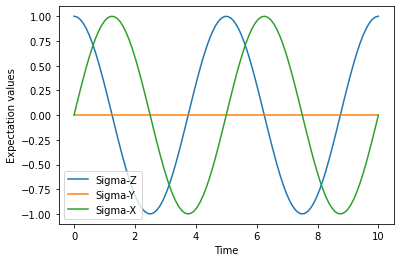

In [118]:
H = 2*np.pi * 0.1 * sigmay()
#H = 2*np.pi*0.1 * (qeye(2)-sigmaz())
psi0 = basis(2, 0)
times = np.linspace(0.0, 10.0, 100)
result = sesolve(H, psi0, times, [sigmaz(), sigmay(),sigmax()])
fig, ax = plt.subplots()
ax.plot(result.times, result.expect[0]) 
ax.plot(result.times, result.expect[1]) 
ax.plot(result.times, result.expect[2]) 
ax.set_xlabel('Time') 
ax.set_ylabel('Expectation values') 
ax.legend(("Sigma-Z", "Sigma-Y","Sigma-X")) 
plt.show() 



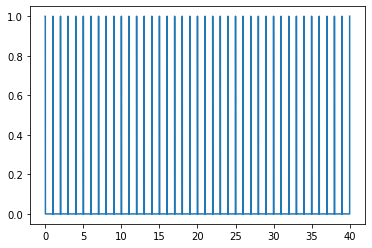

In [142]:
n = 40 #number of pulses
pw = 1e-3 #pulse width

def sfq_pulses2(n,T_sep):
    """
    This returns n pulses separeted by T_sep with magnitude 1 instead of Vmax
    """
    t = np.linspace(0,T_sep*n,n*10000)
    pulses = ddf(t,pw)
    for i in range(n):
        pulses = np.add(pulses,ddf(t-T_sep*(i+1),pw))
    return t,pulses


times,pulses = sfq_pulses2(n,1)
V_sfq = sp.interp1d(times,pulses)

plt.plot(times,V_sfq(times))

def Ht(t):
    # args[0] = n
    # args[1] = T_sep
    H_free = hbar*omega*0.5*(qeye(2)-sigmaz())
    H_sfq = C_c*V_sfq(t)*np.sqrt(hbar * omega * (1/(2*C)))*sigmay()
    return H_free + H_sfq



In [151]:
n = 100
psi0 = basis(2, 0)
tsep = 1 #seperation between pulses

print(hbar*omega*0.5)
print(C_c*0.002*np.sqrt(hbar * omega * (1/(2*C))))

a1 = hbar*omega*0.5
a2 = C_c*0.002*np.sqrt(hbar * omega * (1/(2*C)))

c1 = a1/(a1+a2)
c2 = a2/(a1+a2)


t = np.linspace(0,tsep*n,1000)

# times,pulses = sfq_pulses2(n+2,tsep)
# V_sfq = sp.interp1d(times,pulses) #create continuous function

def H_coeffs(t,args):
    times,pulses = sfq_pulses2(n+2,tsep)
    V_sfq = sp.interp1d(times,pulses)
    return V_sfq(t)

H_free = c1*(qeye(2)-sigmaz())
H_sfq = c2*sigmay()
Ht = [H_free, [H_sfq,H_coeffs]]

result = sesolve(Ht,psi0,t,[sigmaz(),sigmay(),sigmaz()])
fig, ax = plt.subplots()
ax.plot(result.times, result.expect[0]) 
ax.plot(result.times, result.expect[1]) 
ax.plot(result.times, result.expect[2]) 
ax.set_xlabel('Time') 
ax.set_ylabel('Expectation values') 
ax.legend(("Sigma-Z", "Sigma-Y", "Sigma-X")) 
plt.show() 



1.65651753648502e-24
2.5741154103769474e-24


KeyboardInterrupt: 

1.65651753648502e-24
2.5741154103769474e-24
0.3915531215521135
0.6084468784478866


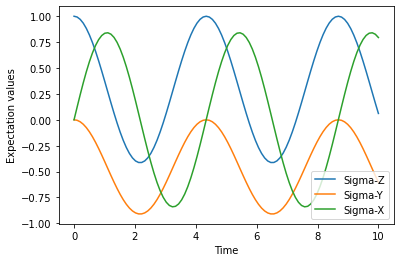

In [154]:
n = 20
psi0 = basis(2, 0)
tsep = 1 #seperation between pulses

print(hbar*omega*0.5)
print(C_c*0.002*np.sqrt(hbar * omega * (1/(2*C))))

a1 = hbar*omega*0.5
a2 = C_c*0.002*np.sqrt(hbar * omega * (1/(2*C)))

c1 = a1/(a1+a2)
c2 = a2/(a1+a2)

print(c1)
print(c2)

H = c2*sigmay() + c1*(qeye(2)-sigmaz())
#H = c1*(qeye(2)-sigmaz())

psi0 = basis(2, 0)
times = np.linspace(0.0, 10.0, 100)
result = sesolve(H, psi0, times, [sigmaz(), sigmay(),sigmax()])
fig, ax = plt.subplots()
ax.plot(result.times, result.expect[0]) 
ax.plot(result.times, result.expect[1]) 
ax.plot(result.times, result.expect[2]) 
ax.set_xlabel('Time') 
ax.set_ylabel('Expectation values') 
ax.legend(("Sigma-Z", "Sigma-Y","Sigma-X")) 
plt.show() 



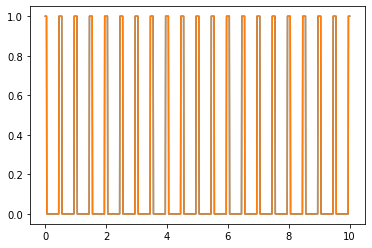

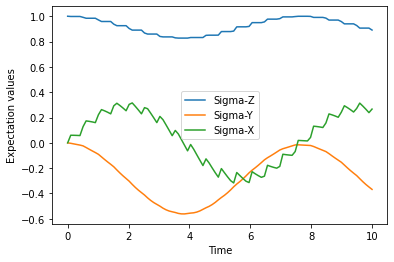

In [210]:
H0 = c1*(qeye(2)-sigmaz())
H1 = c2*sigmay()

def ddf(x,width):
    val = np.zeros_like(x)
    val[(-(width/2)<=x) & (x<=(width/2))] = 1
    return val

width = 0.1
tsep = 0.5
n=20

times = np.linspace(0,10,1000)
test_func = sp.interp1d(times,ddf(times,width))
# plt.plot(times,ddf(times,width))
# plt.plot(times,test_func(times))

pulses = ddf(times,width)
for i in range(n):
    pulses = np.add(pulses,ddf(times-(i+1)*tsep,width))
pulse_func = sp.interp1d(times,pulses)

plt.plot(times,pulses)
plt.plot(times,pulse_func(times))


# def H1_coeffs(t,args):
#     times = np.linspace(0,11,1000)
#     val = ddf(times,width)
#     func = sp.interp1d(times,val)
#     return func(t)

def H1_coeffs(t,args):
    times = np.linspace(0,11,1000)
    pulses = ddf(times,width)
    for i in range(n):
        pulses = np.add(pulses,ddf(times-(i+1)*tsep,width))
    pulse_func = sp.interp1d(times,pulses)
    return pulse_func(t)

H = [H0,[H1,H1_coeffs]]


psi0 = basis(2, 0)
times = np.linspace(0.0, 10.0, 100)
result = sesolve(H, psi0, times, [sigmaz(), sigmay(),sigmax()])
fig, ax = plt.subplots()
ax.plot(result.times, result.expect[0]) 
ax.plot(result.times, result.expect[1]) 
ax.plot(result.times, result.expect[2]) 
ax.set_xlabel('Time') 
ax.set_ylabel('Expectation values') 
ax.legend(("Sigma-Z", "Sigma-Y","Sigma-X")) 
plt.show() 
    
    
